An analysis of cifar5m data-scaling of adversarial training.

### Load libraries

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
import wandb.sdk

In [2]:
sys.path.append("../..")
from src.utils import runs_to_df

### Load data

In [3]:
api = wandb.Api()
runs: list[wandb.sdk.wandb_run.Run] = api.runs(
    f"data-frugal-learning/adv-train",
    filters={"tags": {"$in": ["try1.2", "try1.2.1", "try1.3", "smaller-wrns"]}},
)

df = runs_to_df(runs).query(
    "&".join(
        [
            "do_adv_training",
            "(dataset == 'DatasetT.CIFAR5m' | dataset.isnull())",
            "(state == 'finished' | state == 'running')",
        ]
    )
)
len(df)


85

In [4]:
print(sorted(df.n_train.unique()))
print(df.groupby(["depth", "width"]).count().step)
print(df.query("state == 'finished'").groupby(["depth", "width"]).count().step)

[50, 80, 100, 200, 300, 500, 1000, 2000, 5000, 10000, 20000, 50000, 200000, 500000, 2000000, 5942688]
depth  width
10     2         8
       10       11
16     5        11
       10       11
28     5        11
       10       16
       20       16
Name: step, dtype: int64
depth  width
10     2         1
16     10       10
28     5        11
       10       16
       20       16
Name: step, dtype: int64


### Plots

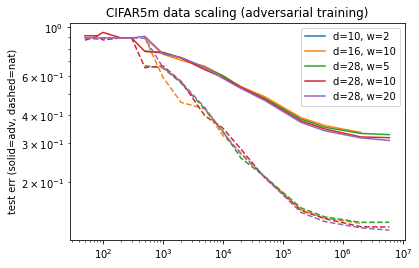

In [6]:
for d, w in df.groupby(["depth", "width"]).count().index:
    cdf = df.query(f"depth == {d} & width == {w} & ~test_acc_adv.isnull()").sort_values("n_train")
    if len(cdf) == 0:
        continue
    
    line, = plt.plot(cdf.n_train, 1 - cdf.test_acc_adv, label=f"{d=}, {w=}")
    plt.plot(cdf.n_train, 1 - cdf.test_acc_nat, linestyle="--", color=line.get_color())

plt.title("CIFAR5m data scaling (adversarial training)")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("test err (solid=adv, dashed=nat)")
plt.legend();